In [ ]:
from selenium import webdriver
from time import sleep

skip = 0
player_lst = []
for i in range(10):
    url = f"https://api.tracker.gg/api/v1/valorant/standard/leaderboards?type=ranked&platform=pc&board=default&region=global&act=16118998-4705-5813-86dd-0292a2439d90&skip={skip}&take=100"

    driver_path = "/Users/kahunghe/Documents/GitHub/GE2324_GP9/chromedriver"
    driver = webdriver.Chrome(executable_path=driver_path)
    driver.get(url)
    skip += 100
    df = eval(driver.page_source.replace("""</pre><div class="json-formatter-container"></div></body></html>""","").replace("""<html><head><meta name="color-scheme" content="light dark"><meta charset="utf-8"></head><body><pre>""","").replace('null','None').replace('false','False').replace('true','True'))
    for i in df['data']['items']:
        player_lst.append(i['id'])
    sleep(10)
driver.quit()

with open('players.txt','w') as f:
    f.write(str(player_lst))

print(player_lst)

In [ ]:
len(player_lst)

In [ ]:

from random import randint
for player in player_lst[3:20]:
    try:
        #from player get all match id
        player = player.replace('#','%23')
        pages = 0

        match_id_lst = []
        for i in range(30):
            url = f"https://api.tracker.gg/api/v2/valorant/standard/matches/riot/{player}?type=competitive&season=&agent=all&map=all&next={pages}"

            driver_path = "/Users/kahunghe/Documents/GitHub/GE2324_GP9/chromedriver"
            driver = webdriver.Chrome(executable_path=driver_path)
            driver.get(url)
            pages+=1
            df = eval(driver.page_source.replace("""</pre><div class="json-formatter-container"></div></body></html>""","").replace("""<html><head><meta name="color-scheme" content="light dark"><meta charset="utf-8"></head><body><pre>""","").replace('null','None').replace('false','False').replace('true','True'))
            for j in df['data']['matches']:
                round_data = j['segments'][0]['stats']
                round_data_processed = {}
                for k in round_data:
                    round_data_processed = round_data_processed | {k:round_data[k]['value']}

                match_id_lst.append({"id":j['attributes']['id'],"map":j['attributes']['mapId']} |
                                    {'result':j['segments'][0]['metadata']['result']} |
                                    round_data_processed)
            
            

            sleep(randint(60,120))
        driver.quit()

        print(len(match_id_lst))
        #save to txt
        with open(f'matches/{player}_match_id.txt','w') as f:
            f.write(str(match_id_lst))
    except Exception as e:
        print(f"Error: {player}", e)
        sleep(120)
        continue

    


In [ ]:
with open('matches/kupecc%23111_match_id.txt','r') as f:
    match_id_lst = eval(f.read())
match_id_lst

In [ ]:
map_set = set([i['map'] for i in match_id_lst])
map_set
    

In [ ]:
# get all match history


import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import json
import pandas as pd


for player_match in match_data:
    try:
        for match in player_match:
            match_id = match['id']
            match_url = f"https://api.tracker.gg/api/v2/valorant/standard/matches/{match_id}"

            driver_path = "/Users/kahunghe/Documents/GitHub/GE2324_GP9/chromedriver"
            driver = webdriver.Chrome(executable_path=driver_path)
            driver.get(match_url)    
            sleep(randint(60,120))
            #to dict
            match_test_df = json.loads(driver.page_source.replace("""</pre><div class="json-formatter-container"></div></body></html>""","").replace("""<html><head><meta name="color-scheme" content="light dark"><meta charset="utf-8"></head><body><pre>""",""))

            driver.quit()
            with open(f'match_data/{match_id}.txt','w') as f:
                f.write(str(match_test_df))
    except Exception as e:
        print(f"Error: {match['id']}", e)
        sleep(120)
        continue


    # segments = []
    # target_map = [i['id'] for i in match_id_lst if i['map'] == '/Game/Maps/Ascent/Ascent']
    # print(len(target_map))
    # for match_id in target_map:

    #     match_url = f"https://api.tracker.gg/api/v2/valorant/standard/matches/{match_id}"

    #     driver_path = "/Users/kahunghe/Documents/GitHub/GE2324_GP9/chromedriver"
    #     driver = webdriver.Chrome(executable_path=driver_path)
    #     driver.get(match_url)    
    #     sleep(5)
    #     #to dict
    #     match_test_df = json.loads(driver.page_source.replace("""</pre><div class="json-formatter-container"></div></body></html>""","").replace("""<html><head><meta name="color-scheme" content="light dark"><meta charset="utf-8"></head><body><pre>""",""))

    #     driver.quit()
        
    #     segments += match_test_df["data"]["segments"]








In [ ]:
#load all match data
import pandas as pd
match_data = []
#open all text file in matches folder
import os
for file in os.listdir('match_data'):
    with open(f'match_data/{file}','r') as f:
        match_data.append(eval(f.read()))

match_data


#####too slow！！


In [1]:
#multi threading reading
import concurrent.futures
import time
import os

def read_file(file):
    with open(f'match_data/{file}','r') as f:
        return eval(f.read())
    
start = time.time()
with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(read_file, os.listdir('match_data'))


match_data = list(results)





In [ ]:
len(match_data)

In [ ]:

import seaborn as sns
import scipy
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

for match in match_data:
    points = []
    points_killer = []
    # if match['data']['metadata']['mapName'] != 'Abyss':
    #     continue
    map_img = match["data"]["metadata"]['mapDetails']['imageUrl']

    response = requests.get(map_img)
    image = Image.open(BytesIO(response.content))
    image_width, image_height = image.size

    xMultiplier = match["data"]["metadata"]['mapDetails']['xMultiplier']
    yMultiplier = match["data"]["metadata"]['mapDetails']['yMultiplier']
    xScalarToAdd = match["data"]["metadata"]['mapDetails']['xScalarToAdd']
    yScalarToAdd = match["data"]["metadata"]['mapDetails']['yScalarToAdd']


    for i in match['data']['segments']:
        if i['type'] == 'player-round-kills':
            killer = i['attributes']['platformUserIdentifier']
            #i dont know why but the x and y is flipped,but it works
            y_t = (i['metadata']['opponentLocation']['x'] * yMultiplier + yScalarToAdd) * image_width
            x_t = (i['metadata']['opponentLocation']['y'] * xMultiplier + xScalarToAdd) * image_height
            if x_t > 0 and x_t < image_width and y_t > 0 and y_t < image_height:
                points.append((x_t,y_t))


            
            for j in i['metadata']['playerLocations']:
                if(j['platformUserIdentifier'] == killer):
                    #i dont know why but the x and y is flipped,but it works
                    y_t = (j['location']['x'] * yMultiplier + yScalarToAdd) * image_width
                    x_t = (j['location']['y'] * xMultiplier + xScalarToAdd) * image_height
                    if x_t > 0 and x_t < image_width and y_t > 0 and y_t < image_height:
                        points_killer.append((x_t,y_t))


    


    plt.figure(figsize=(15, 15))

    plt.imshow(image)

    #add 4 corners,for better image
    points.append((0,0))
    points_killer.append((0,0))
    points.append((image_width,image_height))
    points_killer.append((image_width,image_height))
    points.append((0,image_height))
    points_killer.append((0,image_height))
    points.append((image_width,0))
    points_killer.append((image_width,0))


    if len(points) > 0:
        sns.kdeplot(
            x=[i[0] for i in points], y=[i[1] for i in points], 
            cmap="Reds", fill=True, alpha=0.4, thresh=0,bw_method = 0.1
        )

    if len(points_killer) > 0:
        sns.kdeplot(
            x=[i[0] for i in points_killer], y=[i[1] for i in points_killer], 
            cmap="Greens", fill=True, alpha=0.4, thresh=0,bw_method = 0.1
        )


    plt.scatter(*zip(*points), color='red', s=5, marker='x', alpha=0.3)
    plt.scatter(*zip(*points_killer), color='green', s=5, marker='x', alpha=0.3)
    plt.axis("off")
    plt.savefig(f"images/{match['data']['metadata']['mapName']}_{match['data']['attributes']['id']}.png",bbox_inches='tight', pad_inches=0)
    #plt.show()




In [11]:
#load player data to df
import pandas as pd
import os

matches = []
for file in os.listdir('matches'):
    with open(f'matches/{file}','r') as f:
        m = eval(f.read())
        for i in m:
            i['player'] = file.replace('_match_id.txt','')
            matches.append(i)

        



In [17]:
df = pd.DataFrame(matches)

df.to_csv('matches.csv',index=False)



In [18]:
df.columns

Index(['id', 'map', 'result', 'playtime', 'roundsPlayed', 'roundsWon',
       'roundsLost', 'roundsDisconnected', 'placement', 'score', 'kills',
       'deaths', 'assists', 'damage', 'damageReceived', 'headshots',
       'grenadeCasts', 'ability1Casts', 'ability2Casts', 'ultimateCasts',
       'dealtHeadshots', 'dealtBodyshots', 'dealtLegshots', 'econRating',
       'suicides', 'revived', 'firstBloods', 'firstDeaths', 'lastDeaths',
       'survived', 'traded', 'kasted', 'kAST', 'flawless', 'thrifty',
       'antiEco', 'totalThrifty', 'totalAntiEco', 'manAdvantage',
       'manDisadvantage', 'aces', 'teamAces', 'clutches', 'clutchesLost',
       'plants', 'defuses', 'kdRatio', 'scorePerRound', 'damagePerRound',
       'headshotsPercentage', 'damageDelta', 'damageDeltaPerRound', 'rank',
       'trnPerformanceScore', 'player'],
      dtype='object')

/var/folders/y4/_hfv_1c12c5dst33jlmwh_g80000gn/T/ipykernel_39984/4018748414.py:29: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_normalized.corr(),annot=False)


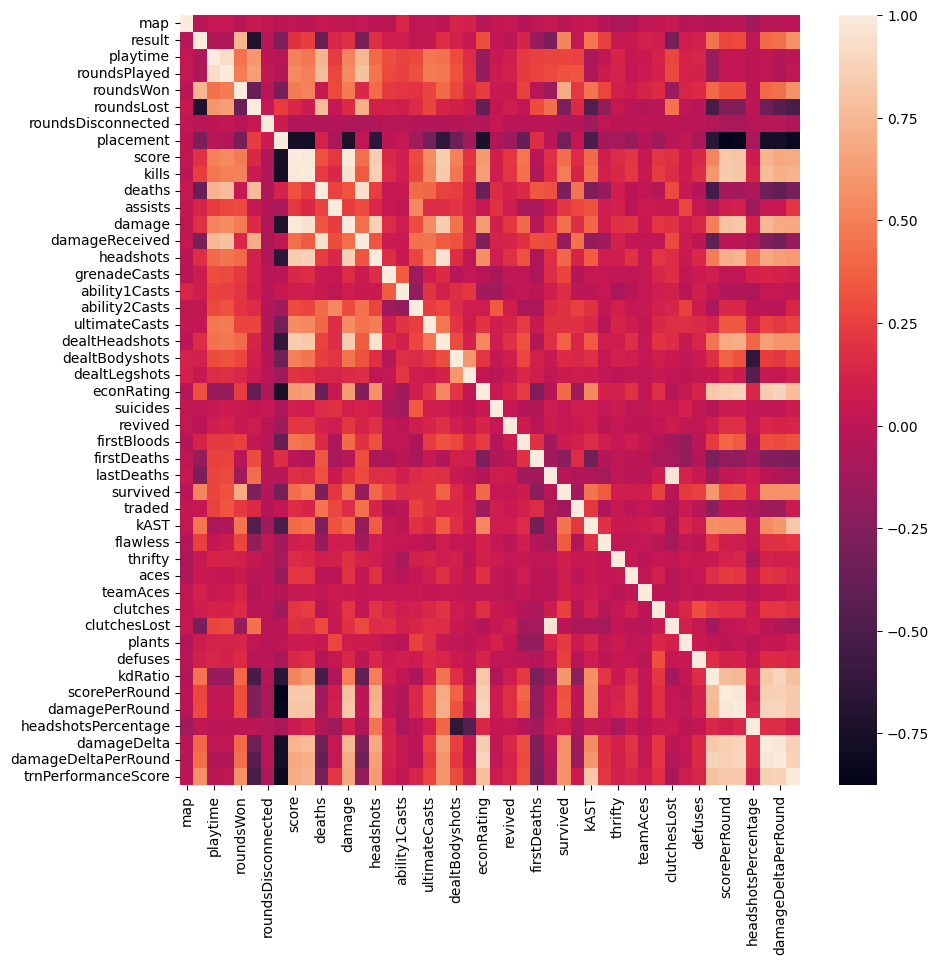

In [32]:
#corrlations
import seaborn as sns
import matplotlib.pyplot as plt

#drop all non numeric columns
df_normalized = df.drop(['kasted','antiEco','totalThrifty','totalAntiEco','manAdvantage','manDisadvantage','rank'],axis=1)
#fill 0 to nan
df_normalized = df_normalized.fillna(0)
#change result -1 for loss, 1 for win 0 for tie
df_normalized['result'] = df_normalized['result'].apply(lambda x: 1 if x == 'victory' else -1 if x == 'defeat' else 0)
#Percentage to decimal
df_normalized['headshotsPercentage'] = df_normalized['headshotsPercentage']/100
#map to number
map_dict = {'/Game/Maps/Ascent/Ascent':1,
            '/Game/Maps/Bonsai/Bonsai':2,
            '/Game/Maps/Bind/Bind':3,
            '/Game/Maps/Foxtrot/Foxtrot':4,
            '/Game/Maps/Icebox/Icebox':5,
            '/Game/Maps/Split/Split':6,
            '/Game/Maps/TheRange/TheRange':7}
df_normalized['map'] = df_normalized['map'].map(map_dict)



#heatmap
plt.figure(figsize=(10,10))
#trun off number in the heatmap
df_corr = df_normalized.drop(['id'],axis=1)
sns.heatmap(df_normalized.corr(),annot=False)

plt.show()
